# Extractive Text Summarization with Natural Language Processing
<div style="text-align: right"><br>TextRank: Bringing Order into Texts, Mihalcea et al., 2004</div>

<p align="center">
  <img src="https://i.imgur.com/KdBhz4c.png" alt="sharead"></img>
</p>

# Introduction

Staying relevant in the ever changing technology landscape can be a challenge. At work, we are expected to keep abreast of new computer technologies, web design feels like a constant game of catch up and quitting the race for only a few months months will result in your skill set becoming obsolete.

In short, we can see how knowledge gradually becomes its own unique and important form of currency at a fundamental level. Common resources for developers to brush up their skills include books, podcasts, blog posts, trending GitHub repos, and YouTube videos.

With hundreds of tech talks shared daily, YouTube won in recent years popularity amongst developers - being more commonly their first choice to inform themselves about current technologies. Unfortunately, more often than not these type of videos challenge us to allocate a great chunk of time from our daily life. Expected video lenght range from 20 minutes up to 3 hours, with a busy working schedule we simply put don't have time to watch YouTube videos.

In a recent thread, a Hacker News user wrote:

>*Time management, to me, is a more powerful “skill up” than anything that could keep your GitHub green. When you know you have limited hours in the day and you have hard time commitments, you have no choice but to learn and work efficiently.*

Browsing myself Hacker News for nearly six years, one topic wich regularly shows up is **staying up to date** (Figure 1). Users indicate that they have no time for almost anything besides their day-to-day job.
With methods known from natural language processing, is it possible to densify the content from a YouTube video into one comprehensible PDF file?

<p align="center">
  <img src="https://i.imgur.com/T4ZaB1N.png" alt="hackernews" width="70%"></img>
</p>
<center>Figure 1: Recent threads on Hacker News</center>

# Objective
YouTube videos provide us with auto-generated subtitles. **sharead.app** aims to develop a model to extract useful bits of knowledge from subtitles and provide the user with a PDF file containing the summary.

# Scraping the data

YouTubes captions are stored in a XML tree, which can be easily scraped.

In [1]:
import re
from html import parser, unescape
from urllib.request import urlopen
from xml.etree import ElementTree

import requests
from bs4 import BeautifulSoup


class YouTubeSubtitles:
    class CouldNotFetchSubtitles(Exception):
        """Raises an exception if subtitles could not be found."""

        def __init__(self, youtube_id: str):
            super().__init__(
                f"Could not fetch the appropiate subtitles for {youtube_id}")
            self.youtube_id = youtube_id

    @staticmethod
    def get_subtitle(youtube_id: str) -> list:
        """Retrieves the subtitle for the video."""
        try:
            youtube_id = _LinkParser(youtube_id).parse_url()
            return _SubtitleFetcher(youtube_id).parse()
        except Exception:
            raise YouTubeSubtitles.CouldNotFetchSubtitles(youtube_id)


class WebsiteText:
    @staticmethod
    def get_text(url: str) -> tuple:
        """Extracts all the paragraph text from an arbitrary webpage."""

        site = urlopen(url)
        soup = BeautifulSoup(site, "lxml")
        text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
        return soup.title.text, text


class _LinkParser:
    """Extracts unique video id from youtube link."""

    def __init__(self, youtube_link: str):
        self.youtube_link = youtube_link

    def parse_url(self) -> str:
        if 'watch?v' in self.youtube_link:
            youtube_id = re.findall(r'^[^=]+=([^&]+)', self.youtube_link)
        elif 'youtu.be/' in self.youtube_link:
            youtube_id = re.findall(r'youtu\.be/([^&]+)', self.youtube_link)
        else:
            raise YouTubeSubtitles.CouldNotFetchSubtitles(self.youtube_link)
        return youtube_id[0]


class _SubtitleFetcher:
    BASE_URL = "https://www.youtube.com/watch?v={youtube_id}"
    YOUTUBE_API = "https://www.youtube.com/api/{api_url}"
    REGEX = re.compile(r'<[^>]*>', re.IGNORECASE)

    def __init__(self, youtube_id: str):
        self.youtube_id = youtube_id

    def fetch(self) -> str:
        website = requests.get(
            self.BASE_URL.format(youtube_id=self.youtube_id)).text
        timedtext_xml = website.find('timedtext')
        url = self.YOUTUBE_API.format(
            api_url=website[timedtext_xml:timedtext_xml +
                            website[timedtext_xml:].find('"')].replace(
                                '\\u0026', '&').replace('\\', ''))
        return requests.get(url).text

    def parse(self) -> list:
        data = self.fetch()
        return [{
            'text': re.sub(self.REGEX, '', unescape(xml_element.text)),
            'start': float(xml_element.attrib['start']),
        } for xml_element in ElementTree.fromstring(data)]

# Example

Let's take a look at this talk about linear models.
The video is over 43 minutes long. Can it be summarized?

video url: https://www.youtube.com/watch?v=68ABAU_V8qI

<p align="center">
  <img src="https://i.imgur.com/Y3mNx3M.png" alt="techtalk" width="100%"></img>
</p>

Scraping the subtitles is the first step for sharead.app

In [3]:
from pprint import pprint
xml_struct = YouTubeSubtitles.get_subtitle(
    "https://www.youtube.com/watch?v=68ABAU_V8qI")
pprint(xml_struct[:20])
talk_title = "Winning with Simple, even Linear, Models"
raw_text = ' '.join([i['text'] for i in xml_struct])

[{'start': 7.719, 'text': 'all right everyone thanks for dropping'},
 {'start': 10.91, 'text': "to my talk today I'll be talking about"},
 {'start': 12.65, 'text': 'how you can win was simple and even some'},
 {'start': 14.36, 'text': "linear models and as a reason why I'm a"},
 {'start': 16.46, 'text': 'little bit passionate about this because'},
 {'start': 17.66, 'text': 'if you are living on the internet or in'},
 {'start': 20.09, 'text': 'our sort of little filter bubble you may'},
 {'start': 21.95, 'text': 'have heard variants of this quote'},
 {'start': 23.27, 'text': 'something in a line of you should be'},
 {'start': 24.59, 'text': 'using deep learning and typically the'},
 {'start': 26.599, 'text': 'people who tell you this or people like'},
 {'start': 27.98, 'text': 'blogs reddit hacker news and some'},
 {'start': 29.48, 'text': 'YouTube stars and especially the latter'},
 {'start': 32.63, 'text': 'one is kind of weird because people are'},
 {'start': 33.8, 'text': 'rapping a

# Exploratory Data Analysis

In [4]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk as nlp
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud

plt.style.use('seaborn-notebook')
%matplotlib inline

Number of words: 9736
Number of unique words: 1379


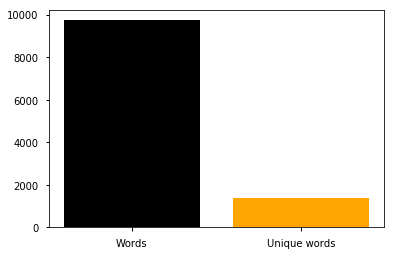

In [5]:
def plot_number_words(raw_text: str):
    n_words = len(raw_text.split())
    n_unique_words = len(set(raw_text.split()))
    print('Number of words: {}\nNumber of unique words: {}'.format(
        n_words, n_unique_words))
    height = [n_words, n_unique_words]
    bars = ("Words", "Unique words")
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height, color=['black', 'orange'])
    plt.xticks(y_pos, bars)
    plt.plot()

plot_number_words(raw_text)

[]

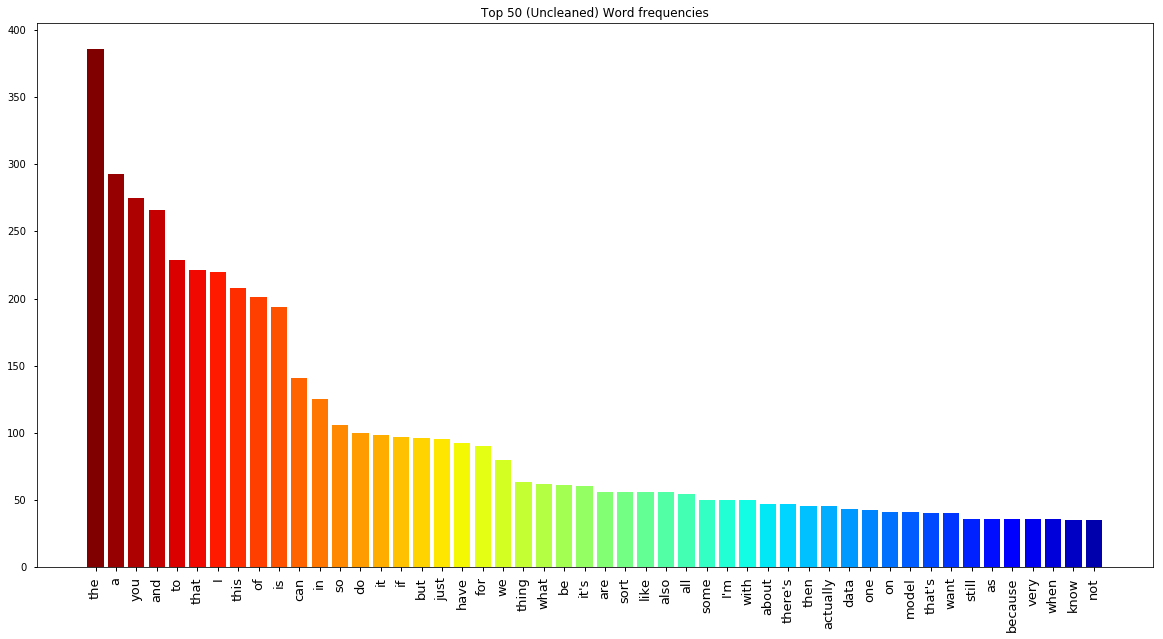

In [6]:
word_list = raw_text.split()
counts = dict(Counter(word_list).most_common(50))

labels, values = zip(*counts.items())
indSort = np.argsort(values)[::-1]
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

cmap = plt.cm.get_cmap('jet')
colors = cmap(np.arange(cmap.N))[::-5]
plt.figure(figsize=(20, 10))
plt.bar(indexes, values, color=colors)
plt.xticks(indexes, labels, fontsize=13, rotation=90)
plt.title("Top 50 (Uncleaned) Word frequencies")
plt.plot()

## Word clouds

Before creating a word cloud, we want to remove stopwords and lemmatize the text corpus.

In [7]:
wordnet_lemmatizer = WordNetLemmatizer()
words = set(stopwords.words('german')) | set(stopwords.words('english'))
raw_text = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in raw_text.split() if word not in words)

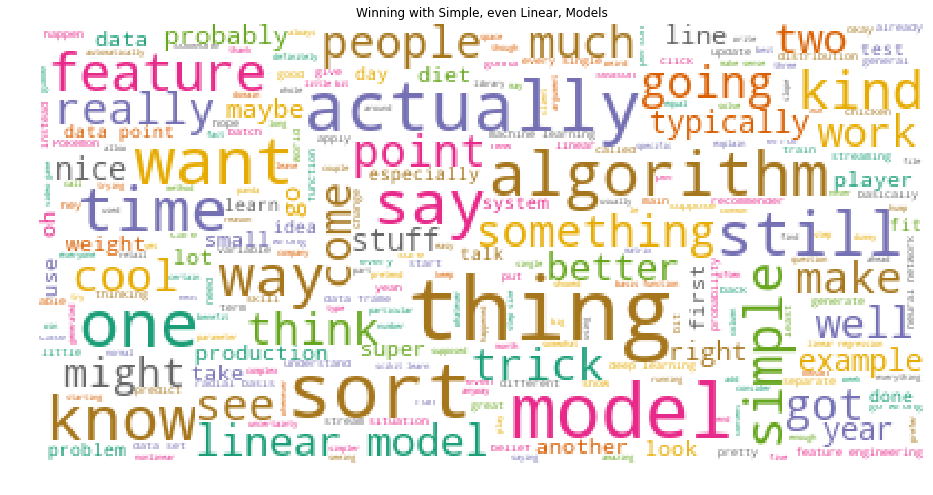

In [8]:
plt.figure(figsize=(24, 18))
plt.subplot(211)
wc = WordCloud(
    background_color="white",
    max_words=1000,
    stopwords=STOPWORDS,
    max_font_size=40)
wc.generate(raw_text)
plt.title(talk_title)
plt.imshow(wc.recolor(colormap='Dark2', random_state=6))
plt.axis('off');

# Subtitles summary

Following approach implements TextRank: Bringing Order into Texts, Mihalcea et al. 2004

### GloVe: Global Vectors for Word Representation

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [39]:
import networkx as nx
import numpy as np
import pandas as pd
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity


class ExtractiveSummary:
    """
    Graph-based ranking algorithm for extractive summaries,
    based on top of PageRank.
    """

    def __init__(self, raw_text: tuple, top_k: int=10):
        self.raw_text = raw_text
        self.top_k = top_k
        self._summary = ''

    def get_summary(self) -> str:
        """Creates an extractive summary based on input text corpus."""
        summarize_text = []
        clean_sentences, sentences = self.create_clean_sentences()
        sentence_vector = SentenceVector('glove.6B.100d.txt', clean_sentences)
        sim_mat = SimilarityMatrix(sentence_vector.vector, clean_sentences, len(sentences))
        nx_graph = nx.from_numpy_array(sim_mat.matrix)
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(
            ((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        for i in range(self.top_k):
            summarize_text.append(ranked_sentences[i][1])
        self._summary = ' '.join(summarize_text)
        return self._summary
        

    def create_clean_sentences(self):
        self.raw_text = (talk_title, self.raw_text)
        sentences = []
        for s in self.raw_text:
            sentences.append(sent_tokenize(str(s)))

        sentences = [y for x in sentences for y in x]
        clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")
        clean_sentences = [s.lower() for s in clean_sentences]
        stop_words = set(stopwords.words('english')) | set(
            stopwords.words('german'))

        def _filter_stopwords(sentence):
            sen_new = " ".join(
                [sen for sen in sentence if sen not in stop_words])
            return sen_new

        clean_sentences = [
            _filter_stopwords(r.split()) for r in clean_sentences
        ]
        return clean_sentences, sentences
    
    def __repr__(self):
        return self._summary


class SimilarityMatrix:
    def __init__(self, sentence_vector, clean_sentences, sentence_lenght):
        self.sentence_vector = sentence_vector
        self.clean_sentences = clean_sentences
        self.sentence_lenght = sentence_lenght
        
    @property
    def matrix(self):
        sim_mat = np.zeros([self.sentence_lenght, self.sentence_lenght])

        for i in range(self.sentence_lenght):
            for j in range(self.sentence_lenght):
                if i != j:
                    sim_mat[i][j] = cosine_similarity(
                        self.sentence_vector[i].reshape(1, 100),
                        self.sentence_vector[j].reshape(1, 100))[0, 0]
        return sim_mat


class SentenceVector:
    def __init__(self, filepath: str, clean_sentences: list):
        self.filepath = filepath
        self.clean_sentences = clean_sentences
        self._sentence_vectors = []

    @property
    def vector(self):
        word_embeddings = dict()
        with open(self.filepath, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                word_embeddings[word] = coefs
        for i in self.clean_sentences:
            if len(i) != 0:
                v = sum([
                    word_embeddings.get(w, np.zeros((100, )))
                    for w in i.split()
                ]) / (len(i.split()) + 0.001)
            else:
                v = np.zeros((100, ))
            self._sentence_vectors.append(v)
        return self._sentence_vectors

Add artificial punctuation every nth sentence.

In [21]:
def synthetic_points(xml_struct, n):
    return ' '.join(
        [v['text'] + '.' * (i % n == 0) for i, v in enumerate(xml_struct)])

# Results

## Summarize YouTube video

In [24]:
text = synthetic_points(xml_struct, 3)
extractive_summary = ExtractiveSummary(text)
summary = extractive_summary.get_summary()
print(summary)

matrix is actually a lot better what I could do though is I just look at this data set sure right now of just these. play a large role and I'll just show you one trick that I really really like and then I hope we all agree that it's a. nice trick and that it will mainly work in linear models what some people do is they make dummy variable hint hint. running too much out of time this is my paper data set whenever I give trainings I always say something about the chick. that I showed you we're sort of obvious things where there's a main knowledge available to actually get the thing done. that we still get all the original variables that we're creating the only thing that's been added is we also get. approach can be on the live system and especially useful when you've got labels coming in it actually come in on the. this I know so this is usually the point in time we never want to get started so just like the the small bit of energy. always able to find a way to get it to production even 

## Summarize Wikipedia Webpage

In [41]:
url = 'https://en.wikipedia.org/wiki/Linear_model'
website_text = WebsiteText.get_text(url)
extractive_summary_website = ExtractiveSummary(website_text)
summary_website = extractive_summary_website.get_summary()
print(summary_website)

Alternatively, one may say that the predicted values corresponding to the above model, namely\n are linear functions of the βj.\n Given that estimation is undertaken on the basis of a least squares analysis, estimates of the unknown parameters βj are determined by minimising a sum of squares function\n From this, it can readily be seen that the "linear" aspect of the model means the following:\n An example of a linear time series model is an autoregressive moving average model. Note that here the "linear" part of the term "linear model" is not referring to the coefficients φi and θi, as it would be in the case of a regression model, which looks structurally similar.\n There are some other instances where "nonlinear model" is used to contrast with a linearly structured model, although the term "linear model" is not usually applied. In this instance the use of the term "linear model" refers to the structure of the above relationship in representing Xt as a linear function of past values 